In [1]:
import rpy2
import scipy
import logging
import warnings
import anndata2ri
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import decoupler as dc
import scrublet as scr
import decoupler as dc
from scipy import sparse
from anndata import AnnData
from tabnanny import verbose
import matplotlib.pyplot as plt
from gsva_prep import prep_gsva
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from typing import Optional, Union
from matplotlib.pyplot import rcParams
from functions import pathway_analyses
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from rpy2.robjects.conversion import localconverter

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



-----
anndata     0.8.0
scanpy      1.9.1
-----
OpenSSL                     22.0.0
PIL                         9.2.0
absl                        NA
anndata2ri                  1.1
appnope                     0.1.2
asttokens                   NA
astunparse                  1.6.3
attr                        21.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
boto3                       1.26.32
botocore                    1.29.32
bottleneck                  1.3.5
brotli                      NA
certifi                     2022.09.24
cffi                        1.15.1
cloudpickle                 2.2.0
colorama                    0.4.4
cryptography                38.0.1
cycler                      0.10.0
cython_runtime              NA
dask                        2022.11.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
decoupler                   1.4.0
defusedxml                  0.7.1
de

# **hdWGCNA Network Visualizaion**

In [4]:
%%R
suppressPackageStartupMessages({
    library(WGCNA)
    library(Matrix)
    library(viridis)
    library(harmony)
    library(ggpubr)
    library(tictoc)
    library(RColorBrewer)
    library(Hmisc)
    library(corrplot)
    library(grid)
    library(gridExtra)
    library(igraph)
    library(ggrepel)
    library(conflicted)

    # single-cell analysis package
    library(Seurat)

    # plotting and data science packages
    library(tidyverse)
    library(cowplot)
    library(patchwork)

    # co-expression network analysis packages:
    library(WGCNA)
    library(hdWGCNA)

    # gene enrichment packages
    library(enrichR)
    library(GeneOverlap)


    library(GSEABase)
    library(GSVA) 
# needs to be run every time you start R and want to use %>%
})

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

# optionally enable multithreading
# enableWGCNAThreads(nThreads = 4)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

## **Prepare data**

Now, we load the preprocessed and annotated data for downstream analysis.

In [5]:
save_prefix = 'leng_etc'
map_meta = True
deg_method =  'DESeq2-Wald'
test_names = ['late_vs_early', 'early_vs_no', 'late_vs_no', 'ad_vs_no']
filter_genes = "TRUE"
subject_id = 'PatientID'                # for leng this is `PatientID` for mathys is 'Subject', and 'individualID' for allen
gene_celltype_threshold = 0.05          # determines number of cells the gene must be expressed in 
covariates = ['None']                   # list of covariates to be accounted for in regression.
gene_selection = 'custom'               # specifies the gene selection method when setting up seurat object for WGCNA. The th
celltypes = ["Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC"] #["Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC"]
metadata = f'../data/raw/{save_prefix}/{save_prefix}_metadata.csv' 
meta = pd.read_csv(metadata, encoding_errors='ignore')

gene_selection = 'custom'   # specifies the gene selection method when setting up seurat object for WGCNA. The th
                            # Posible values are "custom", "fraction", "variable"
                            # If custom, a list of genes must be passed.

## **Load Seurat object for Network Visualizations**

In [6]:
%%R -i subject_id -i gene_celltype_threshold -i celltypes -i test_names -i save_prefix -i gene_selection -o seurat_obj

seurat_obj <- list()

for (cell_type in celltypes) {
    
    print(paste0('Loading data for hdWGCNA Experiment in ', toupper(cell_type)))
    tryCatch({
        seurat_obj[[cell_type]] <- readRDS(paste0("../results/hdWGCNA/SeuratObject/", save_prefix, '/', cell_type, '_hdWGCNA_object.rds'))
        print(seurat_obj[[cell_type]])
    
    }, error = function(e){
        NULL
    }, message = function(m){
        print(paste0('Could not load data for ', toupper(cell_type)))
    })

}

print('loaded data')

[1] "Loading data for hdWGCNA Experiment in EXCITATORY"
An object of class Seurat 
16585 features across 10449 samples within 1 assay 
Active assay: originalexp (16585 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap
[1] "Loading data for hdWGCNA Experiment in INHIBITORY"
An object of class Seurat 
16585 features across 5207 samples within 1 assay 
Active assay: originalexp (16585 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap
[1] "Loading data for hdWGCNA Experiment in ASTROCYTE"
An object of class Seurat 
16585 features across 5851 samples within 1 assay 
Active assay: originalexp (16585 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap
[1] "Loading data for hdWGCNA Experiment in MICROGLIA"
An object of class Seurat 
16585 features across 5892 samples within 1 assay 
Active assay: originalexp (16585 features, 2000 variable features)
 3 dimensional reductions 

In [7]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

# **Network Visualization**


Here, we visualize the co-expression networks made with hdWGCNA using the following functions:

- `ModuleNetworkPlot`, visualizes a separate network plot for each module, showing the top N genes by kME.
- `HubGeneNetworkPlot`, visualizes the network comprisng all modules with a given number of hub genes per module.
- `ModuleUMAPPlot`, visualizes all of the genes in the co-expression simultaneously using the UMAP dimensionality reduction algorithm.

## **Individual module network plots**


Here we demonstrate using the `ModuleNetworkPlot` function to visualize the network underlying the top 25 hub genes for each module. By default, this function creates a new folder called “ModuleNetworks”, and generates a .pdf figure for each module.



In [8]:
%%R -i seurat_obj -o seurat_obj

fig_dir = paste0('../results/hdWGCNA/NetworkPlot/', save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){

  print(paste0('Module network plots in hdWGCNA Experiment for ', toupper(cell_type)))

  # individual module networks
  ModuleNetworkPlot(
    seurat_obj[[cell_type]],
    mods = "all",
    outdir = paste0(fig_dir, cell_type, '_hubNetworks/')
  )
}

[1] "Module network plots in hdWGCNA Experiment for EXCITATORY"
Writing output files to ../results/hdWGCNA/NetworkPlot/leng_etc/Excitatory_hubNetworks/Selecting by kME_EXC-M1
Selecting by kME_EXC-M2
Selecting by kME_EXC-M3
Selecting by kME_EXC-M4
Selecting by kME_EXC-M5
[1] "EXC-M1"
[1] "EXC-M2"
[1] "EXC-M3"
[1] "EXC-M4"
[1] "EXC-M5"
[1] "Module network plots in hdWGCNA Experiment for INHIBITORY"
Writing output files to ../results/hdWGCNA/NetworkPlot/leng_etc/Inhibitory_hubNetworks/Selecting by kME_INH-M1
Selecting by kME_INH-M2
Selecting by kME_INH-M3
Selecting by kME_INH-M4
Selecting by kME_INH-M5
[1] "INH-M1"
[1] "INH-M2"
[1] "INH-M3"
[1] "INH-M4"
[1] "INH-M5"
[1] "Module network plots in hdWGCNA Experiment for ASTROCYTE"
Writing output files to ../results/hdWGCNA/NetworkPlot/leng_etc/Astrocyte_hubNetworks/Selecting by kME_AST-M1
Selecting by kME_AST-M2
Selecting by kME_AST-M3
Selecting by kME_AST-M4
[1] "AST-M1"
[1] "AST-M2"
[1] "AST-M3"
[1] "AST-M4"
[1] "Module network plots in hd

In this network, each node represents a gene, and each edge represents the co-expression relationship between two genes in the network. Each of these module network plots are colored based on the color column in the hdWGCNA module assignment table GetModules(seurat_obj). The top 10 hub genes by kME are placed in the center of the plot, while the remaining 15 genes are placed in the outer circle.

Optionally, certain visualization parameters can be changed in this plot:

- `edge.alpha`: determines the opacity of the network edges
- `vertex.size`: determines the size of the nodes
- `vertex.label.cex`: determines the font size of the gene label


In [9]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

## **Combined hub gene network plots**

Here we will make a network plot combining all of the modules together using the `HubGeneNetworkPlot` function. 

This function takes the top n hub genes, and other randomly selected genes, and constructs a joint network using the force-directed graph drawing algorithm. For visual clarity, the number of edges in the network can be downsampled using the edge_prop parameter. In the following example, we visualize the top 3 hub genes and 6 other genes per module.



In [10]:
%%R -i seurat_obj -o seurat_obj



  fig_dir = paste0("../results/hdWGCNA/HubGeneNetworkPlot/", save_prefix, '/')
  if (!dir.exists(fig_dir)) {
    dir.create(fig_dir, recursive=TRUE)
  }


for (cell_type in names(seurat_obj)){

  print(paste0('Hubs Gene Network Plot in hdWGCNA Experiment for ', toupper(cell_type)))

  # hubgene network

  # Save plot to PDF
  pdf(file = paste0(fig_dir,  cell_type, "_allHubGeneNetwork.pdf"), width = 4, height = 4, useDingbats = FALSE)
  HubGeneNetworkPlot(
    seurat_obj[[cell_type]],
    n_hubs = 6,
    n_other=3,
    edge_prop = 0.75,
    mods = 'all',
    sample_edges = TRUE,
    return_graph = FALSE,
    edge.alpha = 0.25,
    vertex.label.cex = 0.25,
    hub.vertex.size = 6,
    other.vertex.size = 2,
    wgcna_name = NULL,

  )
  dev.off()

}

[1] "Hubs Gene Network Plot in hdWGCNA Experiment for EXCITATORY"
Selecting by kME_EXC-M1
Selecting by kME_EXC-M2
Selecting by kME_EXC-M3
Selecting by kME_EXC-M4
Selecting by kME_EXC-M5

  grey EXC-M1 EXC-M2 EXC-M3 EXC-M4 EXC-M5 
     3      9      9      9      8      9 
[1] "#d8443c" "grey90"  "#1f6e9c" "#f4c40f" "#de597c" "#fe9b00"
[1] "here"
[1] 354   4
[1] "Hubs Gene Network Plot in hdWGCNA Experiment for INHIBITORY"
Selecting by kME_INH-M1
Selecting by kME_INH-M2
Selecting by kME_INH-M3
Selecting by kME_INH-M4
Selecting by kME_INH-M5

INH-M1 INH-M2 INH-M3   grey INH-M4 INH-M5 
     9      9      9      3      9      9 
[1] "#f4c40f" "grey90"  "#fe9b00" "#1f6e9c" "#d8443c" "#de597c"
[1] "here"
[1] 335   4
[1] "Hubs Gene Network Plot in hdWGCNA Experiment for ASTROCYTE"
Selecting by kME_AST-M1
Selecting by kME_AST-M2
Selecting by kME_AST-M3
Selecting by kME_AST-M4

AST-M1   grey AST-M2 AST-M3 AST-M4 
     9      3      9      9      9 
[1] "#1f6e9c" "grey90"  "#d8443c" "#fe9b00"
[1

In [11]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

As in the previous network plot, each node represents a gene and each edge represents a co-expression relationship. In this network, `we color intramodular edges with the module’s color, and intermodular edges gray.` The opacity of edges in this network is scaled by the strength of the co-expression relationship.

## **Applying UMAP to co-expression networks**

We have only visualized a subset of the co-expression network with an emphasis on the hub genes. Here, we use an alternative approach to visualize all genes in the co-expression network simultaneously. UMAP is a suitable method for visualizing high-dimensional data in two dimensions, and here we apply UMAP to embed the hdWGCNA network in a low-dimensional manifold.

hdWGCNA includes the function `RunModuleUMAP to run the UMAP algorithm on the hdWGCNA topological overlap matrix (TOM)`. For the UMAP analysis, we subset the columns in the TOM to only contain the top n hub genes by kME for each module. 

Therefore, the organization of each gene in UMAP space is dependent on that gene’s connectivity with the network’s hub genes. This function leverages the UMAP implementation from the uwot R package, so additional UMAP parameters for the uwot::umap function such as min_dist or spread can be included in RunModuleUMAP.

The following code demonstrates using the RunModuleUMAP function with 10 hub genes per module:

In [12]:
%%R -i seurat_obj -o seurat_obj


for (cell_type in names(seurat_obj)){

  print(paste0('Obtaining Module UMAP in hdWGCNA Experiment for ', toupper(cell_type)))

  seurat_obj[[cell_type]] <- RunModuleUMAP(
    seurat_obj[[cell_type]],
    n_hubs = 5, # number of hub genes to include for the UMAP embedding
    n_neighbors=15, # neighbors parameter for UMAP
    min_dist=0.3, # min distance between points in UMAP space
    spread = 2,
  )
}

[1] "Obtaining Module UMAP in hdWGCNA Experiment for EXCITATORY"
Selecting by kME_EXC-M1
Selecting by kME_EXC-M2
Selecting by kME_EXC-M3
Selecting by kME_EXC-M4
Selecting by kME_EXC-M5
[1] "Obtaining Module UMAP in hdWGCNA Experiment for INHIBITORY"
Selecting by kME_INH-M1
Selecting by kME_INH-M2
Selecting by kME_INH-M3
Selecting by kME_INH-M4
Selecting by kME_INH-M5
[1] "Obtaining Module UMAP in hdWGCNA Experiment for ASTROCYTE"
Selecting by kME_AST-M1
Selecting by kME_AST-M2
Selecting by kME_AST-M3
Selecting by kME_AST-M4
[1] "Obtaining Module UMAP in hdWGCNA Experiment for MICROGLIA"
Selecting by kME_MIC-M1
Selecting by kME_MIC-M2
[1] "Obtaining Module UMAP in hdWGCNA Experiment for OLIGODENDROCYTE"
Selecting by kME_OLI-M1
Selecting by kME_OLI-M2
Selecting by kME_OLI-M3


In [13]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

Next we will make a simple visualization of the UMAP for Excitatory cells using ggplot2:

[1] "Store Module UMAP in hdWGCNA Experiment for EXCITATORY"
[1] "Store Module UMAP in hdWGCNA Experiment for INHIBITORY"
[1] "Store Module UMAP in hdWGCNA Experiment for ASTROCYTE"
[1] "Store Module UMAP in hdWGCNA Experiment for MICROGLIA"
[1] "Store Module UMAP in hdWGCNA Experiment for OLIGODENDROCYTE"


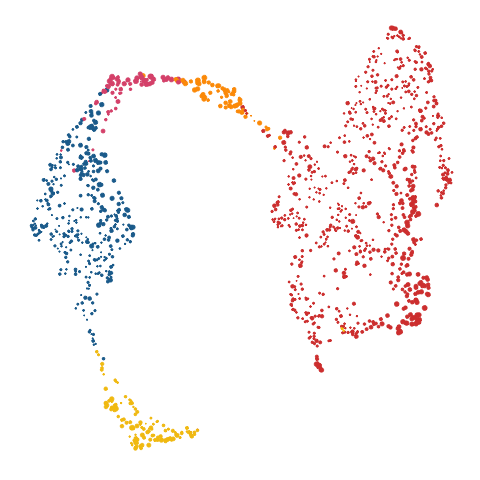

In [14]:
%%R -i seurat_obj -o seurat_obj

# get the hub gene UMAP table from the seurat object

umap_df <- list()

for (cell_type in names(seurat_obj)){

  print(paste0('Store Module UMAP in hdWGCNA Experiment for ', toupper(cell_type)))

  umap_df[[cell_type]] <- GetModuleUMAP(seurat_obj[[cell_type]])

}

# plot sample for Excitatory cells with ggplot
ggplot(umap_df[[celltypes[1]]], aes(x=UMAP1, y=UMAP2)) +
  geom_point(
   color=umap_df[[celltypes[1]]]$color, # color each point by WGCNA module
   size=umap_df[[celltypes[1]]]$kME*2 # size of each point based on intramodular connectivity
  ) +
  umap_theme()

In [15]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

In this plot, each point represents a single gene. The size of each dot is scaled by the gene’s kME for it’s assigned module. ggplot2 is sufficient to visualize the genes in the module UMAP, but here we are not visualizing the underlying network. We can use the function ModuleUMAPPlot to plot the genes and their co-expression relationships.

In [16]:
%%R -i seurat_obj -o seurat_obj

fig_dir = paste0("../results/hdWGCNA/HubGeneUMAP/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){

  print(paste0('UMAP Plot of Connectivities in hdWGCNA Experiment for ', toupper(cell_type)))

  # hubgene network

  pdf(paste0(fig_dir, cell_type, '_hubgene_umap_igraph.pdf'), width=10, height=10)

  ModuleUMAPPlot(
    seurat_obj[[cell_type]],
    edge.alpha = 0.25,
    sample_edges=TRUE,
    keep_grey_edges=FALSE,
    edge_prop=0.1,  # proportion of edges to sample (10% here) # taking the top 10% strongest edges in each module 
    #label_genes = label_genes,
    label_hubs=2 # how many hub genes to plot per module?
  )
  dev.off()
}

[1] "UMAP Plot of Connectivities in hdWGCNA Experiment for EXCITATORY"
Selecting by kME_EXC-M1
Selecting by kME_EXC-M2
Selecting by kME_EXC-M3
Selecting by kME_EXC-M4
Selecting by kME_EXC-M5
[1] "hub labels"
 [1] "SLC26A3"  "SNAP25"   "NLGN1"    "IL1RAPL1" "MAP1B"    "TMSB4X"  
 [7] "DLGAP1"   "SYT1"     "PHACTR1"  "CELF2"   
NULL
 [1] "SLC26A3"  "SNAP25"   "NLGN1"    "IL1RAPL1" "MAP1B"    "TMSB4X"  
 [7] "DLGAP1"   "SYT1"     "PHACTR1"  "CELF2"   
[1] 35900     3
[1] 719   4
[1] "making net"
# A tibble: 6 × 5
# Groups:   color [5]
  Var1   Var2      value color   color_alpha
  <fct>  <fct>     <dbl> <chr>   <chr>      
1 DMD    DMD    0        #fe9b00 #FE9B0000  
2 DOCK10 MAP1B  0        #f4c40f #F4C40F00  
3 MRPS36 CACNB2 0        #1f6e9c #1F6E9C00  
4 BAZ2A  SNAP25 0        #d8443c #D8443C00  
5 NSMCE2 SYT1   0        #de597c #DE597C00  
6 PI4KA  SNAP25 0.000119 #d8443c #D8443C00  
        gene_name module   color  kME_grey kME_EXC-M1 kME_EXC-M2 kME_EXC-M3
KHSRP       KHSRP EXC-M1 #

In [17]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

Next, our hypothesis is that the hub genes are the differentially expressed genes that are in the overlapping pathways.

### **Visualizing Hub Genes: Overlapping Pathways and DEGs**

The hub genes, which are also differentially expressed genes (DEGs), can be visualized in the pathways where they overlap. You can find the results of this analysis saved at `f'../results/{test_name}/{study}_{deg_method}_{cell_type}_DEGs_in_overlapping_pathways.csv.csv` from the previous analysis.

Save to pathway names to R

In [18]:
%%R -i test_names -i deg_method -i seurat_obj -o seurat_obj

conflicts_prefer(base::intersect)

fig_dir = paste0("../results/hdWGCNA/HubGeneUMAP/", save_prefix, '/')

if (!dir.exists(fig_dir)) {
  dir.create(fig_dir, recursive=TRUE)
}

# label the DEGs in the overlapping pathways

for (test in c('ad_vs_no')){

  print(toupper(test))
  for (cell_type in names(seurat_obj)){

    print(paste0('UMAP Plot of Hub-DEG Connectivities in hdWGCNA Experiment for ', toupper(cell_type)))

    # hubgene network

    overlap_degs <- read.csv(paste0('../results/', test, '/', save_prefix, '_', deg_method, '_',
                           cell_type, "_DEGs_in_overlapping_pathways.csv"), header=TRUE)

    hub_genes <- GetHubGenes(seurat_obj[[cell_type]], 25)
    label_genes <- intersect(hub_genes$gene_name, unique(overlap_degs$x))
    
    if (length(label_genes) == 0) {
      print(paste0('No genes to label for ', toupper(cell_type)))
      print('setting label_genes to NULL')
      label_genes <- NULL
    } else {
      label_genes <- label_genes
    }


    pdf(paste0(fig_dir, test, "_", cell_type, '_overlap_hubDEGs_umap_igraph.pdf'), width=10, height=10)
    ModuleUMAPPlot(
      seurat_obj[[cell_type]],
      edge.alpha=0.25,
      sample_edges=TRUE,
      keep_grey_edges=FALSE,
      edge_prop=0.1,  # proportion of edges to sample (10% here) # taking the top 10% strongest edges in each module 
      label_genes = label_genes,
      label_hubs=0 # how many hub genes to plot per module?
    )
    dev.off()
  }

}



[conflicted] Will prefer base::intersect over any other package.
[1] "AD_VS_NO"
[1] "UMAP Plot of Hub-DEG Connectivities in hdWGCNA Experiment for EXCITATORY"
Selecting by kME_EXC-M1
Selecting by kME_EXC-M2
Selecting by kME_EXC-M3
Selecting by kME_EXC-M4
Selecting by kME_EXC-M5
[1] "hub labels"
character(0)
 [1] "FAIM2"   "MAPK1"   "SLC17A7" "CLSTN1"  "THY1"    "ARPP19"  "YWHAG"  
 [8] "PRNP"    "DNM1"    "GPM6A"   "CHN1"    "SNAP25"  "N4BP2L2" "LRRC4C" 
[15] "NLGN1"   "NDUFA4"  "RPL21"   "RPL10"   "RPL7"    "RPL6"    "RPS14"  
[22] "RPL41"   "PRKCB"   "CACNA1A" "CACNA1C"
 [1] "FAIM2"   "MAPK1"   "SLC17A7" "CLSTN1"  "THY1"    "ARPP19"  "YWHAG"  
 [8] "PRNP"    "DNM1"    "GPM6A"   "CHN1"    "SNAP25"  "N4BP2L2" "LRRC4C" 
[15] "NLGN1"   "NDUFA4"  "RPL21"   "RPL10"   "RPL7"    "RPL6"    "RPS14"  
[22] "RPL41"   "PRKCB"   "CACNA1A" "CACNA1C"
[1] 35900     3
[1] 719   4
[1] "making net"
# A tibble: 6 × 5
# Groups:   color [5]
  Var1   Var2     value color   color_alpha
  <fct>  <fct>    <dbl

In [19]:
# convert nested list of Seurat object into Rpy2 object 
seurat_obj =  robjects.ListVector(
                        {
                            cell_type: seurat_obj[cell_type]
                     
                            for cell_type in seurat_obj.keys()
                        }
                    )

# **Save Seurat Object**

In [20]:
%%R -i seurat_obj -o seurat_obj

dat_dir = paste0("../results/hdWGCNA/SeuratObject/", save_prefix, '/')

if (!dir.exists(dat_dir)) {
  dir.create(dat_dir, recursive=TRUE)
}

for (cell_type in names(seurat_obj)){
    
    print(paste0('Saving hdWGCNA object in hdWGCNA Experiment for ', toupper(cell_type)))

    saveRDS(seurat_obj[[cell_type]], file=paste0(dat_dir, cell_type, '_hdWGCNA_object.rds'))

}

[1] "Saving hdWGCNA object in hdWGCNA Experiment for EXCITATORY"
[1] "Saving hdWGCNA object in hdWGCNA Experiment for INHIBITORY"
[1] "Saving hdWGCNA object in hdWGCNA Experiment for ASTROCYTE"
[1] "Saving hdWGCNA object in hdWGCNA Experiment for MICROGLIA"
[1] "Saving hdWGCNA object in hdWGCNA Experiment for OLIGODENDROCYTE"
